# Neighbourhood based query to reference distance finder at gene-level

### An alignment free approach (i.e. no time series alignment) to find genes with different alignment patterns across time.

This analysis involves 3 main steps:

1. Load anndata reference and query objects with the already QC, preprocessed, and log1p normalized gene expression data, along with relevant integrated latent embedding in the obsm (e.g. X_scVI). 
2. Run **NNDistFinder** to compute a distance matrix based on gene expression distributions of query2reference cell neighbourhoods (A query cells x genes matrix)
3. Compute cell-level distances by averaging across all genes
4. Run Non-negative matrix factorization to identify gene modules which show gene expression changes at different stages of cell differentiation 

**Implemented by:** Dinithi Sumanaweera <br>
**NNDistFinder** module computes distributional distances of gene expression for each query cell 
in terms of its own neighbour cells vs. reference neighbour cells. <br>
Cell neighbourhoods are queried using the data structures available in BBKNN package (https://github.com/Teichlab/bbknn). <br>
**Acknowledgement**: Krzysztof Polanski

In [1]:
import anndata
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import scanpy as sc
import platform
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
import time
print(platform.python_version())

3.8.16


## 1. Load data

In [2]:
# load reference and query anndata objects

# example dataset: pan fetal reference and artificial thymic organoid (ATO) datasets
adata_ref = anndata.read_h5ad('adata_ref.h5ad')
adata_query = anndata.read_h5ad('adata_query.h5ad')
c_order = ['IPSC', 'PRIMITIVE_STREAK','MESODERMAL_PROGENITOR', 'ENDOTHELIUM', 'HSC_MPP', 'HSC_MPP/LMPP_MLP/DC2', 'DN(EARLY)_T', 'DN_T', 'DP(P)_T', 'DP(Q)_T', 'ABT(ENTRY)','SP_T']
adata_query.obs['ANNOTATION_COMB'] = pd.Categorical(adata_query.obs['ANNOTATION_COMB'], categories=c_order, ordered=True)

# define cell type annotation obs columan name
ANNOTATION_COLNAME ='ANNOTATION_COMB'

## 2. Run NNDistFinder 

In [3]:
import NNDistFinder

s = time.time()
gene_diff_mat = NNDistFinder.main(adata_ref, adata_query, 'X_scVI', n_neighbours=25)
t = time.time()
print(t-s)
# Took 7.2 min for 17176 query cells across 1371 TFs under 60 processes running in parallel. 

n_neighbours:  25
distance metric:  wasserstein
n_processors:  60
NNDist computation ======


100%|██████████| 17176/17176 [07:04<00:00, 40.48it/s]


Normalizing output ======
434.4469892978668


## 3. Check cell-level average distances

In [4]:
# create adata of gene expression distances 
adata_diff = anndata.AnnData(csr_matrix(gene_diff_mat) )
adata_diff.obs_names = list(adata_query.obs_names) 
adata_diff.var_names = adata_query.var_names
adata_diff.obs[ANNOTATION_COLNAME] = adata_query.obs[ANNOTATION_COLNAME]
adata_diff.obsm['X_umap'] = adata_query.obsm['X_umap']
adata_diff.obs['avg_dist'] = np.mean(gene_diff_mat, axis=1) # average distance across all genes
adata_diff.obs['avg_dist'] = pd.DataFrame(adata_diff.obs['avg_dist']).apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0) # min max dist

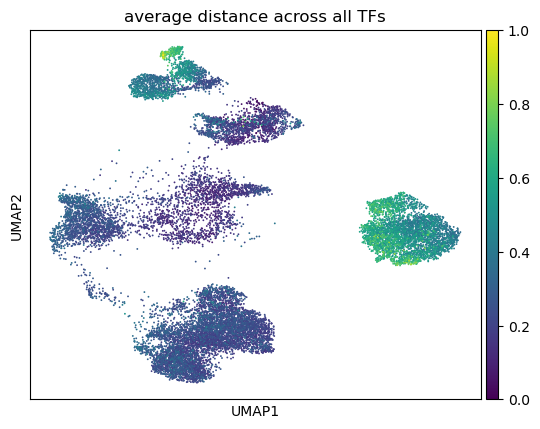

In [5]:
sc.pl.umap(adata_diff, color='avg_dist', title='average distance across all TFs')

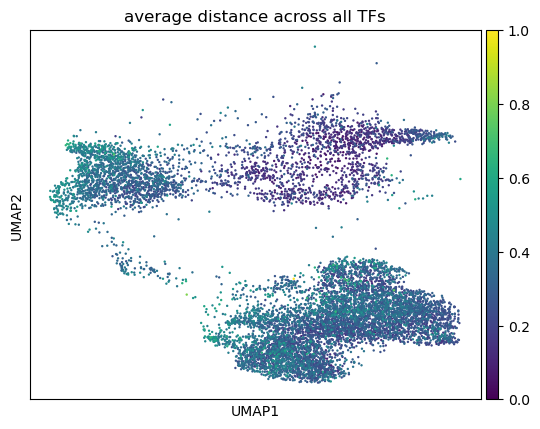

In [6]:
adata_temp = adata_diff[[c not in ['PRIMITIVE_STREAK', 'MESODERMAL_PROGENITOR', 'IPSC','ENDOTHELIUM','HSC_MPP/LMPP_MLP/DC2','HSC_MPP']for c in adata_query.obs['ANNOTATION_COMB']],:]
adata_temp.obs['avg_dist'] = pd.DataFrame(adata_temp.obs['avg_dist']).apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
sc.pl.umap(adata_temp, color='avg_dist', title='average distance across all TFs')

## 4. Run NMF and analyse factors for different alignment patterns across differentiation time

In [7]:
def run_NMF(df, k=10):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(df)
    H = model.components_
    nmf_mat = pd.DataFrame(H).transpose()
    nmf_mat.index = adata_query.var_names
    nmf_mat = nmf_mat.apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)# min-max normalization
    return nmf_mat 

nmf_mat = run_NMF(gene_diff_mat)

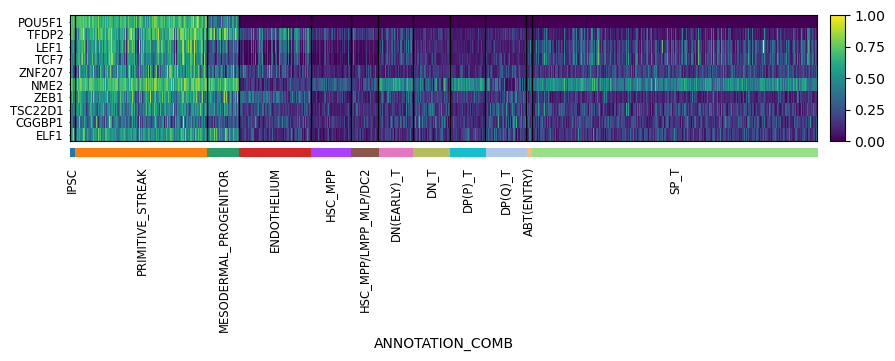

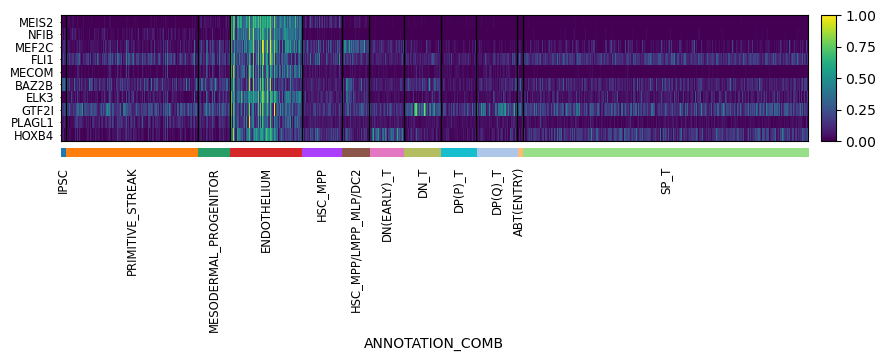

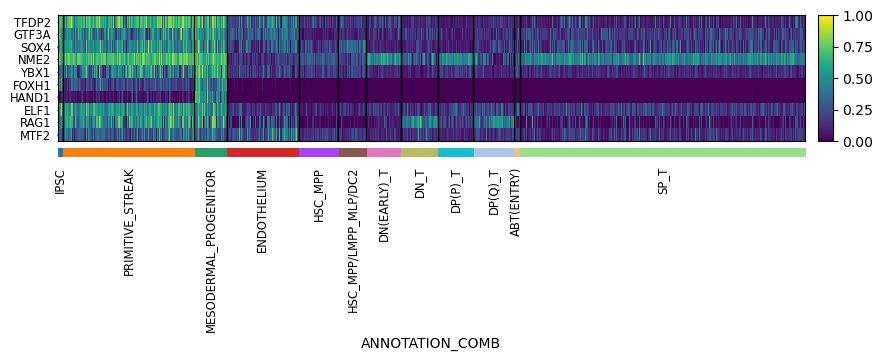

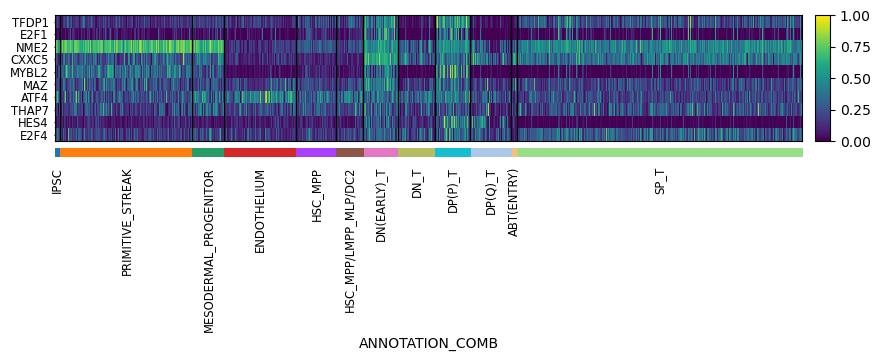

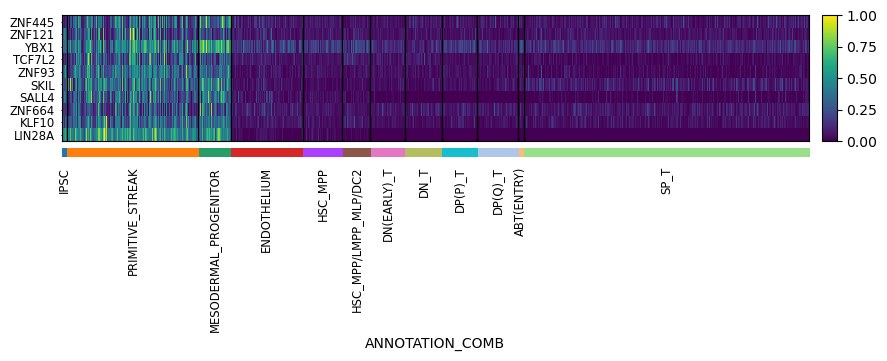

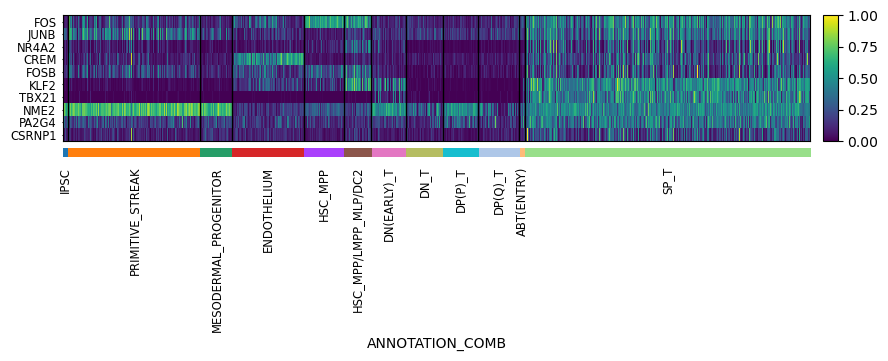

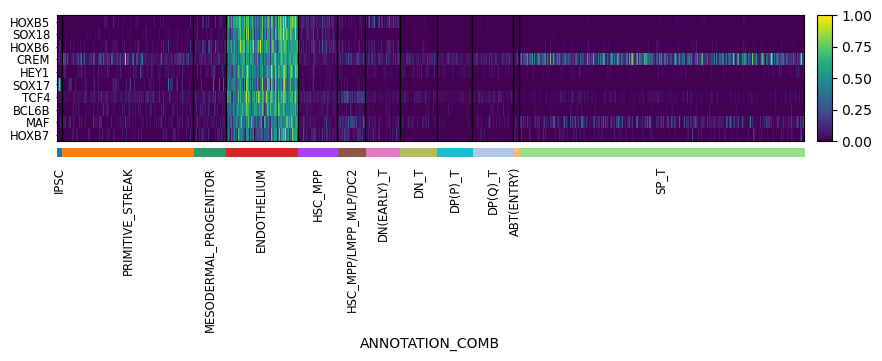

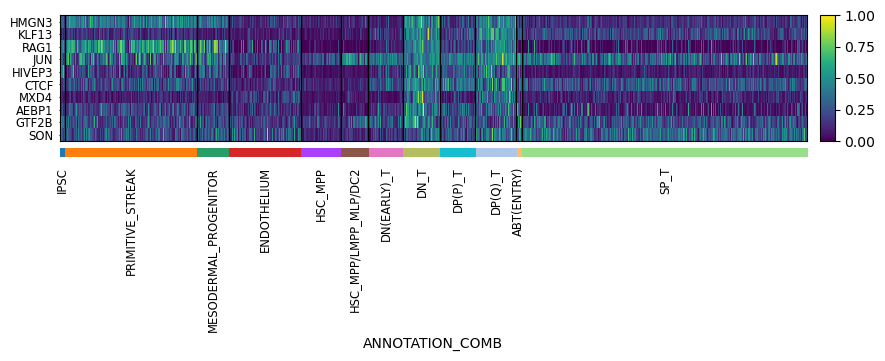

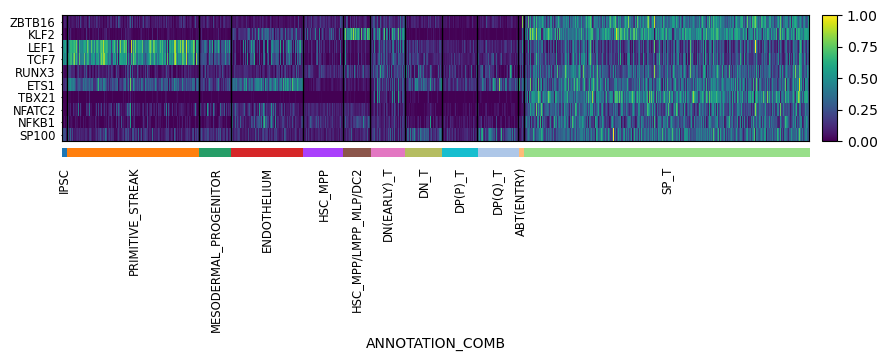

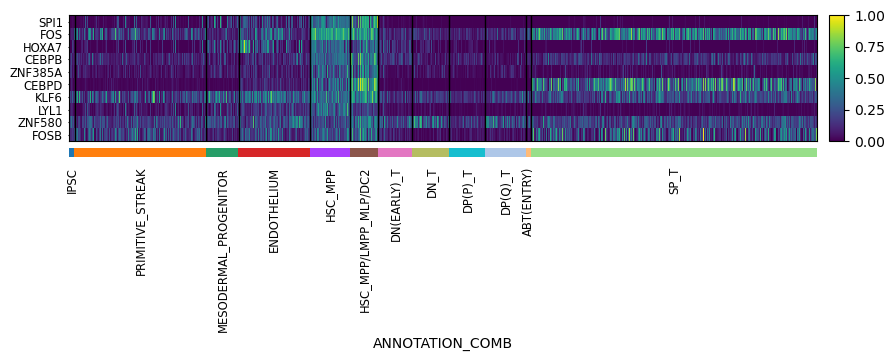

In [11]:
# plotting top genes for each NMF factor 
for factor_id in range(nmf_mat.shape[1]):
    a = nmf_mat.sort_values(by=factor_id, ascending=False)[factor_id]
    top_genes = list(a.index[0:10]) # top 10 genes
    
    #sc.pl.dotplot(adata_diff, top_genes, groupby='ANNOTATION_COMB', dendrogram=False, swap_axes=True)
    sc.pl.heatmap(adata_diff, top_genes, groupby= ANNOTATION_COLNAME, swap_axes=True, vmin =0)